In [1]:
import sys
sys.path.append('/eos/user/l/lkoller/SWAN_projects/data analysis 2024/Data loader')
sys.path.append('/eos/user/l/lkoller/SWAN_projects/data analysis 2024/commands')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from readTrc_4CH import Trc
from tqdm import tqdm
from cluster_finder import cfinder
from PIL import Image
from time import time
import scipy.signal as sci
pd.set_option("display.max_columns",150)

In [2]:
datafile = pd.read_csv('/eos/experiment/gbar/datasummary/datafile24.txt', delimiter = '\t')
dates = ['24_07_06', '24_07_07', '24_07_08']

In [3]:
data = datafile[[True if val in dates else False for val in datafile.Date]]

dfm = data[[True if val in [609,614,616,619,621,622] else False for val in data.run]] #mixing
#dfm = data[[True if val in [614] else False for val in data.run]]
dfm = dfm[dfm.run_mode == 1] #mixing
dfm = dfm[dfm.Positron_Waveform != 'None']
dfm = dfm[dfm.MCP5 != 'None']
dfm = dfm[dfm.NE50_I > 7]
#dfm = dfm[[True if len(sci.find_peaks(-Trc().open(val)[1][1][1380:1480], height = 0, distance = 20, prominence = 0.15)[0]) > 0 else False for val in dfm.Positron_Waveform]]
dfm = dfm[[True if len([1 for val in Trc().open(val)[1][3][1200:1800] if abs(val) > 0.01]) > 8 else False for val in dfm.Positron_Waveform]]

dfb = data[[True if val in [611,617,620,623] else False for val in data.run]] #background
dfb = dfb[dfb.run_mode == 2] #background
dfb = dfb[dfb.MCP5 != 'None']

corr = len(dfm)/len(dfb)

In [18]:
len(data[data.run == 622])

36

In [4]:
flm = list(dfm.MCP5)
flb = list(dfb.MCP5)

#flmm = [flm[val] for val in [8, 90, 95, 111, 145, 309, 383]]

In [5]:
cm = pd.DataFrame(columns = ['filenumber','file','xpos','ypos','size','sum'])

for i in tqdm(range(len(dfm))):
    if flm[i] != 'None':
        temp_c = cfinder(flm[i], min_size = 1)
        temp_c.insert(0, 'file', [flm[i]]*len(temp_c))
        temp_c.insert(0, 'filenumber', [i]*len(temp_c))
        cm = pd.concat([cm, temp_c])
        
cb = pd.DataFrame(columns = ['filenumber','file','xpos','ypos','size','sum'])

for i in tqdm(range(len(dfb))):
    if flb[i] != 'None':
        temp_c = cfinder(flb[i], min_size = 1)
        temp_c.insert(0, 'file', [flb[i]]*len(temp_c))
        temp_c.insert(0, 'filenumber', [i]*len(temp_c))
        cb = pd.concat([cb, temp_c])
        
cm = cm.reset_index(drop = True)
cb = cb.reset_index(drop = True)

100%|██████████| 776/776 [03:23<00:00,  3.82it/s]


In [6]:
sizem = list(cm['size'])
summ = list(cm['sum'])

sizeb = list(cb['size'])
sumb = list(cb['sum'])

corr = len(dfm)/len(dfb)

In [7]:
bins = 260
sumranges = np.linspace(min(summ+sumb), max(summ+sumb), bins+1)
sumhistm = np.histogram(summ, bins = bins, range = (sumranges[0], sumranges[-1]))[0]
sumhistb = np.histogram(sumb, bins = bins, range = (sumranges[0], sumranges[-1]))[0]
sumhistb = np.array([val*corr for val in sumhistb])
sthresh = 76000
print('Number of mixing and background events:', len(dfm), ',', len(dfb))
print('Number of events above', sthresh, ' for mix:', len([1 for val in summ if val >= sthresh]))
print('Number of events above', sthresh, ' for bkg (with and without correction):', len([1 for val in sumb if val >= sthresh]), ',', len([1 for val in sumb if val >= sthresh])*corr)
print('Number of events in mix above', sthresh, 'corrected for bkg (total and per spill):', len([1 for val in summ if val >= sthresh]) - len([1 for val in sumb if val >= sthresh])*corr, ',', (len([1 for val in summ if val >= sthresh]) - len([1 for val in sumb if val >= sthresh])*corr)/len(dfm))

Number of mixing and background events: 468 , 776
Number of events above 76000  for mix: 66
Number of events above 76000  for bkg (with and without correction): 57 , 34.376288659793815
Number of events in mix above 76000 corrected for bkg (total and per spill): 31.623711340206185 , 0.06757203277821834


In [ ]:
#when taking all files from the mixing runs:
#Number of mixing and background events: 504 , 723
#Number of events above 76000  for mix: 72
#Number of events above 76000  for bkg (with and without correction): 53 , 36.946058091286304
#Number of events in mix above 76000 corrected for bkg (total and per spill): 35.053941908713696 , 0.0695514720410986

#when taking out events with no positron waveform file:
#Number of mixing and background events: 450 , 723
#Number of events above 76000  for mix: 66
#Number of events above 76000  for bkg (with and without correction): 53 , 32.98755186721992
#Number of events in mix above 76000 corrected for bkg (total and per spill): 33.01244813278008 , 0.0733609958506224

#when taking out events with no positron waveform file and NE50_I < 7:
#Number of mixing and background events: 447 , 723
#Number of events above 76000  for mix: 66
#Number of events above 76000  for bkg (with and without correction): 53 , 32.767634854771785
#Number of events in mix above 76000 corrected for bkg (total and per spill): 33.232365145228215 , 0.07434533589536513

#when taking out events with no positron waveform file, NE50_I < 7 and no (low) positron peak:
#Number of mixing and background events: 424 , 723
#Number of events above 76000  for mix: 63
#Number of events above 76000  for bkg (with and without correction): 53 , 31.081604426002766
#Number of events in mix above 76000 corrected for bkg (total and per spill): 31.918395573997234 , 0.0752792348443331

#when taking out events with no positron waveform file, NE50_I < 7 and no (low) positron peak without run 609:
#Number of mixing and background events: 259 , 723
#Number of events above 76000  for mix: 29
#Number of events above 76000  for bkg (with and without correction): 53 , 18.986168741355463
#Number of events in mix above 76000 corrected for bkg (total and per spill): 10.013831258644537 , 0.03866344115306771

#when taking out events with no positron waveform file, NE50_I < 7 and no (low) positron peak with run 609 as only mixing run:
#Number of mixing and background events: 165 , 723
#Number of events above 76000  for mix: 34
#Number of events above 76000  for bkg (with and without correction): 53 , 12.095435684647303
#Number of events in mix above 76000 corrected for bkg (total and per spill): 21.904564315352697 , 0.1327549352445618

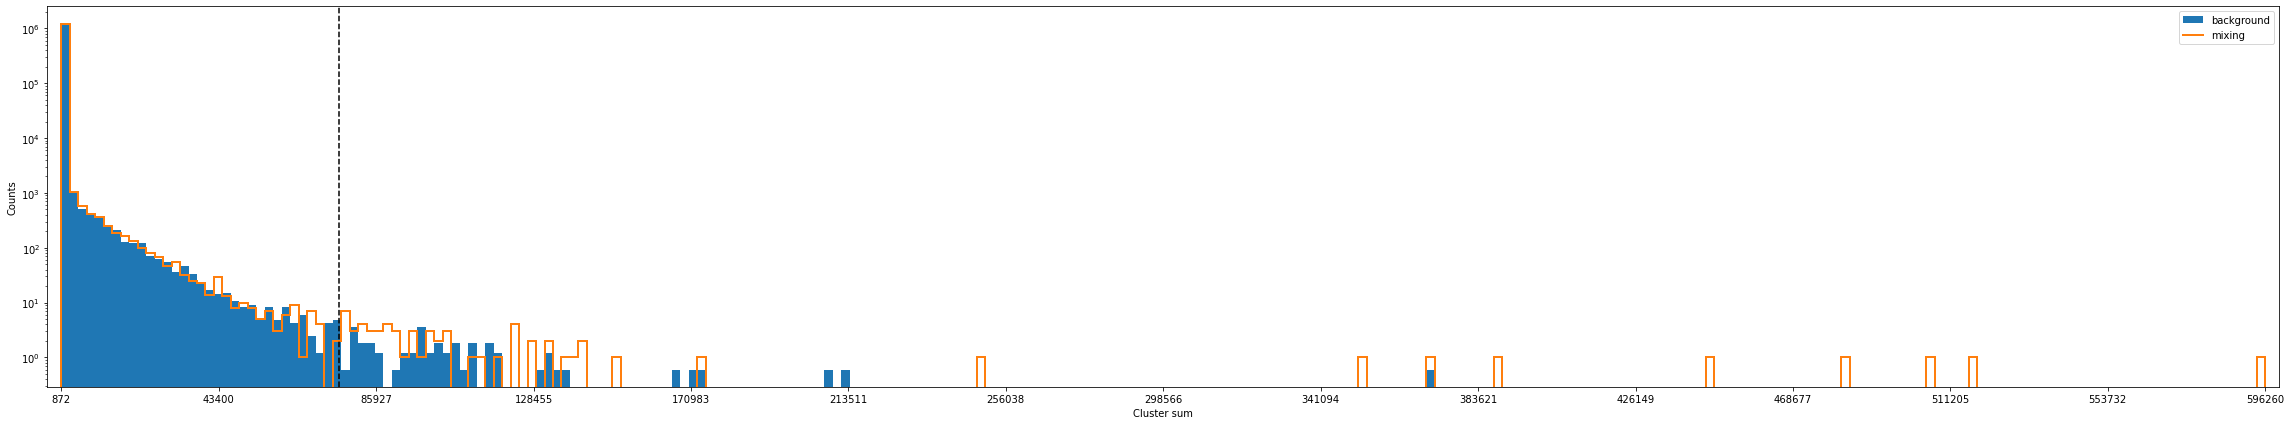

In [19]:
plt.figure(figsize = (40,7))
plt.xlabel('Cluster sum')
plt.ylabel('Counts')
plt.yscale('log')
plt.xlim(-3000, 600000)
plt.xticks([round(val,4) for val in np.linspace(sumranges[0],sumranges[-1],15)])
plt.stairs(sumhistb, sumranges, fill = True, label = 'background')
plt.stairs(sumhistm, sumranges, fill = False, linewidth = 2, label = 'mixing')
#for i in ranges: plt.axvline(i, linestyle = '--', c = 'k', alpha = 0.2)
plt.axvline(sthresh, c = 'k', linestyle = '--')
plt.legend(loc = 'best')

In [346]:
max(sizem+sizeb), min(sizem+sizeb), max(sizem+sizeb) - min(sizem+sizeb)

(567, 3, 564)

In [400]:
np.argmax(sizeb)

767

In [412]:
list(cb.iloc[767:768].file)

['/eos/experiment/gbar/pgunpc/data/24_07_07/PCO-SwY_exp_10_us_1720314646.806.tif']

888.2914402202857 27.185615646667575


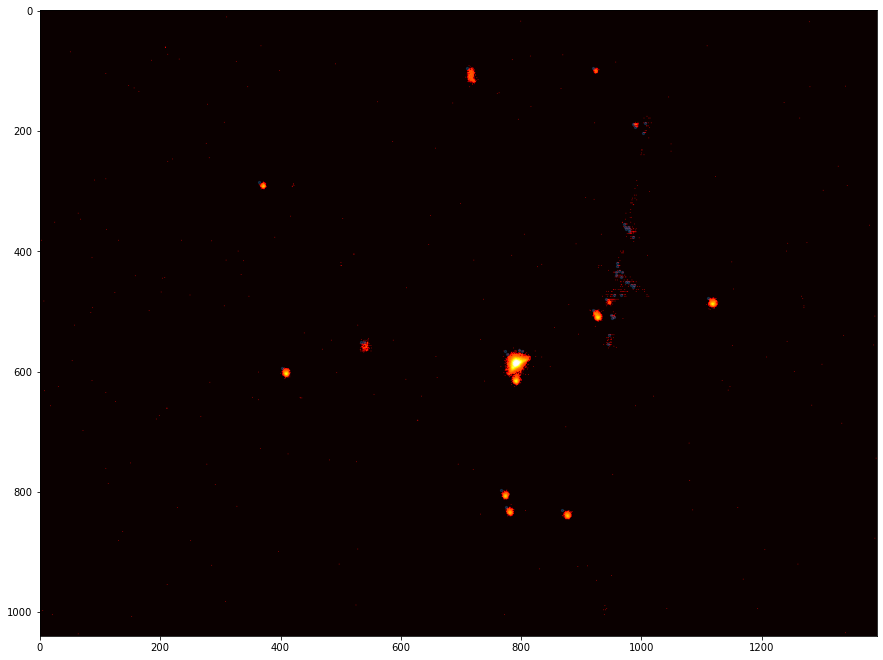

In [463]:
pos = 600

curr_df = cfinder(flpn[pos], min_size = 3)

fig = plt.figure(figsize = (15,15))
arr = np.array(Image.open(flpn[pos]))
thresh = np.average(arr) + 3*np.std(arr)
print(thresh, np.std(arr))
arr[arr < thresh] = 0
arr[arr > 2000] = 2000
#arr = [[(val-thresh)/10+10 if val > 0 else val for val in bal] for bal in arr]
plt.imshow(arr, cmap = 'hot')
plt.scatter(curr_df.ypos, curr_df.xpos, s = 5, alpha = 0.3)

In [295]:
len([1 for bal in arr for val in bal if val > 2000])

59

In [307]:
xposm = list(cm.xpos)
yposm = list(cm.ypos)

xposb = list(cb.xpos)
yposb = list(cb.ypos)

xposlpn = list(clpn.xpos)
yposlpn = list(clpn.ypos)

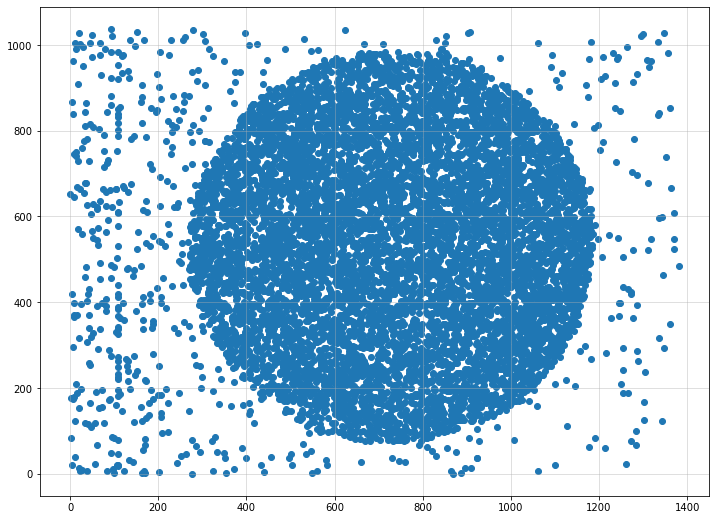

In [314]:
plt.figure(figsize = (12,9))
plt.grid(alpha = 0.5)
plt.scatter(yposm+yposb, xposm+xposb)

In [247]:
max(yposm), max(xposm), max(yposm)/max(xposm)

(1381, 1038, 1.3304431599229287)

In [227]:
cm

,filenumber,file,xpos,ypos,size,sum
0,0,/eos/experiment/gbar/pgunpc/data/24_07_06/PCO-...,0,159,1,892
1,0,/eos/experiment/gbar/pgunpc/data/24_07_06/PCO-...,0,530,1,884
2,0,/eos/experiment/gbar/pgunpc/data/24_07_06/PCO-...,0,550,2,1764
3,0,/eos/experiment/gbar/pgunpc/data/24_07_06/PCO-...,0,986,1,884
4,0,/eos/experiment/gbar/pgunpc/data/24_07_06/PCO-...,1,78,2,1792
...,...,...,...,...,...,...
1881,503,/eos/experiment/gbar/pgunpc/data/24_07_08/PCO-...,1035,1121,1,884
1882,503,/eos/experiment/gbar/pgunpc/data/24_07_08/PCO-...,1036,28,1,880
1883,503,/eos/experiment/gbar/pgunpc/data/24_07_08/PCO-...,1036,167,1,892
1884,503,/eos/experiment/gbar/pgunpc/data/24_07_08/PCO-...,1036,326,1,884


In [125]:
fcm = list(cm[cm['sum'] > 200000].file)
fcb = list(cb[cb['sum'] > 200000].file)
len(fcm), len(fcb)

(9, 3)

In [226]:
len(cm), len(cb)

(1323199, 1888929)

In [196]:
c

,xpos,ypos,size,sum
0,179,625,26,25108
1,318,699,61,61268
2,325,109,3,2652
3,438,858,355,388776
4,601,979,16,15152
5,683,1096,12,11276
6,698,1122,5,4456


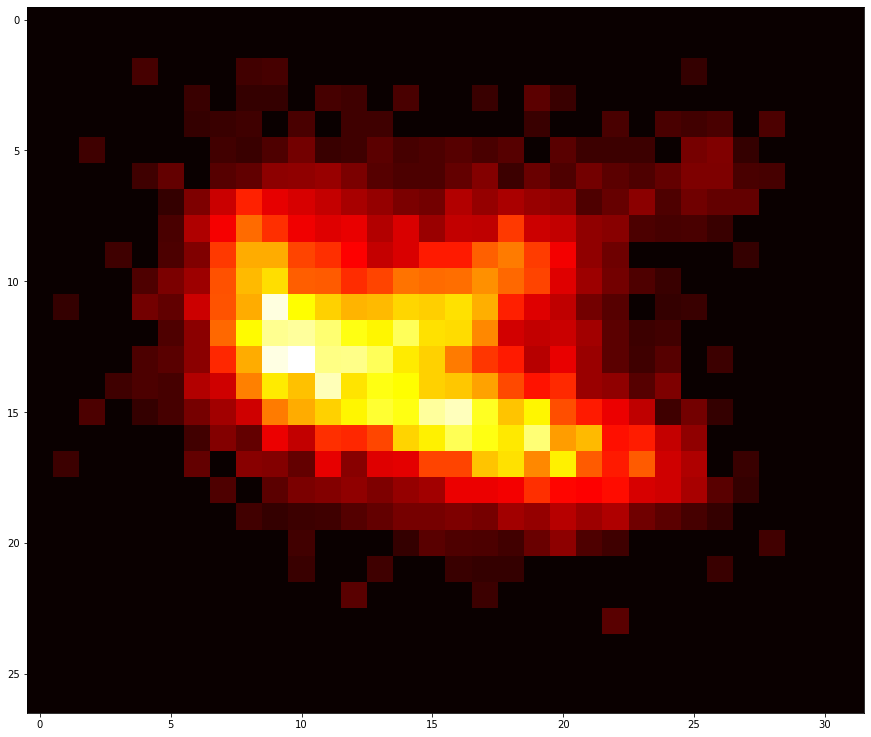

In [199]:
pos = 3
xcurr = c.iloc[pos].xpos
ycurr = c.iloc[pos].ypos

fig = plt.figure(figsize = (15,15))
arr = np.array(Image.open(file))
thresh = np.average(arr) + 3*np.std(arr)
arr = arr[xcurr-2:xcurr+25, ycurr-2:ycurr+30]
arr[arr < thresh] = 0
arr = [[(val-thresh)/10+5 if val > 0 else val for val in bal] for bal in arr]
plt.imshow(arr, cmap = 'hot')

In [11]:
fbadposi = ['/eos/experiment/gbar/pgunpc/data/24_07_06/24_07_06posi/POS1234.1720297524.521.trc','/eos/experiment/gbar/pgunpc/data/24_07_06/24_07_06posi/POS1234.1720297635.634.trc','/eos/experiment/gbar/pgunpc/data/24_07_06/24_07_06posi/POS1234.1720297750.820.trc','/eos/experiment/gbar/pgunpc/data/24_07_06/24_07_06posi/POS1234.1720297869.714.trc','/eos/experiment/gbar/pgunpc/data/24_07_06/24_07_06posi/POS1234.1720297981.792.trc','/eos/experiment/gbar/pgunpc/data/24_07_06/24_07_06posi/POS1234.1720298096.526.trc','/eos/experiment/gbar/pgunpc/data/24_07_06/24_07_06posi/POS1234.1720298215.801.trc','/eos/experiment/gbar/pgunpc/data/24_07_06/24_07_06posi/POS1234.1720298326.899.trc','/eos/experiment/gbar/pgunpc/data/24_07_06/24_07_06posi/POS1234.1720298439.713.trc','/eos/experiment/gbar/pgunpc/data/24_07_06/24_07_06posi/POS1234.1720298556.586.trc','/eos/experiment/gbar/pgunpc/data/24_07_06/24_07_06posi/POS1234.1720298685.702.trc','/eos/experiment/gbar/pgunpc/data/24_07_06/24_07_06posi/POS1234.1720298799.686.trc','/eos/experiment/gbar/pgunpc/data/24_07_06/24_07_06posi/POS1234.1720298916.591.trc','/eos/experiment/gbar/pgunpc/data/24_07_06/24_07_06posi/POS1234.1720299045.690.trc','/eos/experiment/gbar/pgunpc/data/24_07_06/24_07_06posi/POS1234.1720299159.689.trc','/eos/experiment/gbar/pgunpc/data/24_07_06/24_07_06posi/POS1234.1720299276.565.trc','/eos/experiment/gbar/pgunpc/data/24_07_06/24_07_06posi/POS1234.1720299405.694.trc','/eos/experiment/gbar/pgunpc/data/24_07_06/24_07_06posi/POS1234.1720299519.696.trc','/eos/experiment/gbar/pgunpc/data/24_07_06/24_07_06posi/POS1234.1720299765.683.trc','/eos/experiment/gbar/pgunpc/data/24_07_06/24_07_06posi/POS1234.1720299879.683.trc','/eos/experiment/gbar/pgunpc/data/24_07_06/24_07_06posi/POS1234.1720299996.558.trc','/eos/experiment/gbar/pgunpc/data/24_07_06/24_07_06posi/POS1234.1720301319.638.trc']
fbad = list(datafile[[True if val in fbadposi else False for val in datafile.Positron_Waveform]].MCP5)
#12,13,15

In [13]:
len(fbad)

22

873.8949467278314


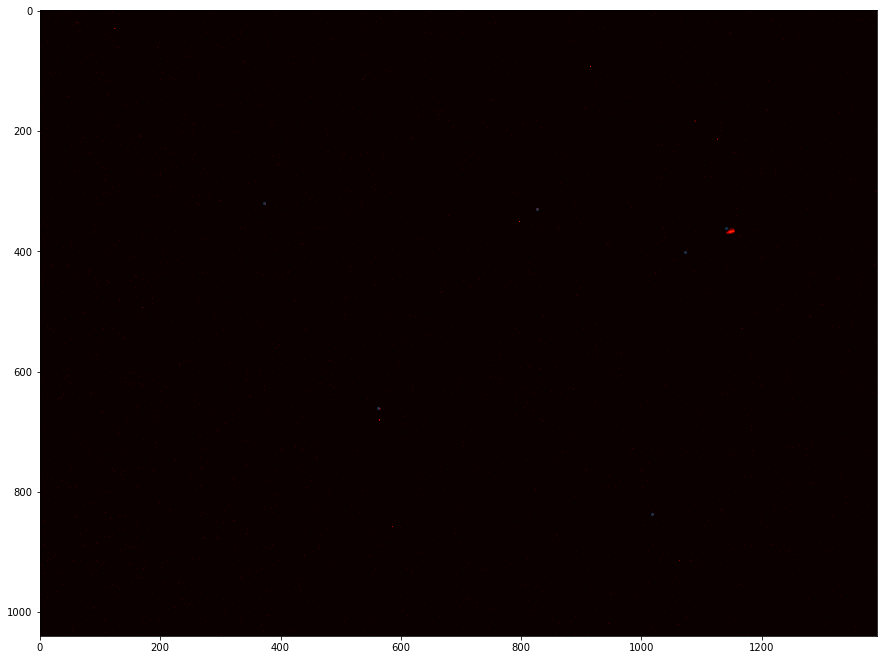

In [46]:
#file = fcm[1]
file = fbad[15]

curr_df = cfinder(file, min_size = 3)

fig = plt.figure(figsize = (15,15))
arr = np.array(Image.open(file))
thresh = np.average(arr) + 3*np.std(arr)
print(thresh)
arr[arr < thresh] = 0
arr[arr > 1500] = 1500
arr = [[(val-thresh)/10+10 if val > 0 else val for val in bal] for bal in arr]
plt.imshow(arr, cmap = 'hot')
plt.scatter(curr_df.ypos, curr_df.xpos, s = 5, alpha = 0.3)

In [45]:
curr_df

,xpos,ypos,size,sum
0,79,109,3,2660
1,138,602,3,2680
2,257,513,3,3660
3,270,643,5,4500
4,377,1086,118,124136
5,387,1085,3,2660
6,455,1043,4,4272
7,541,502,10,9188
8,578,466,13,11944
9,662,738,9,8144


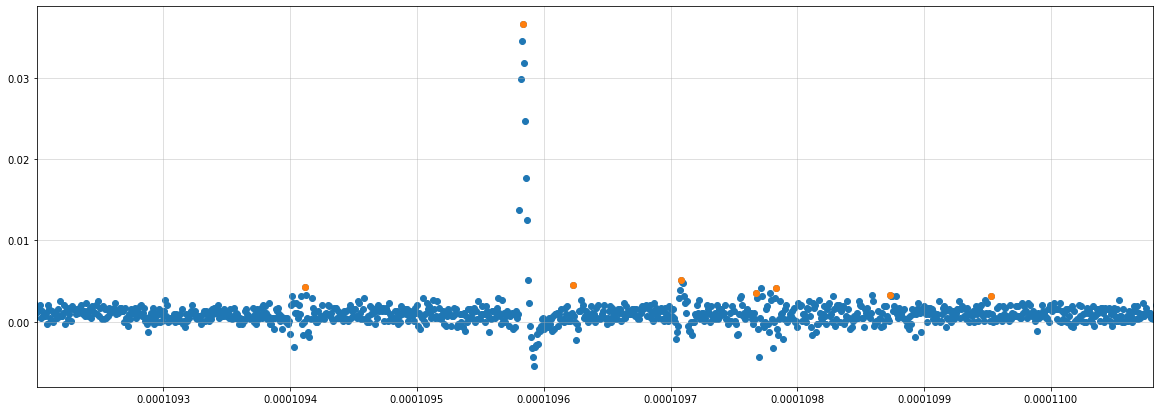

In [219]:
wf_file = list(datafile[datafile.MCP5 == file].Waveform_12bit)[0]
lims = [7750, 8850]

curr_data = Trc().open(wf_file)
pcurr = sci.find_peaks(curr_data[1][2][lims[0]:lims[1]], 0.003, distance = 20, prominence = 0.004)

plt.figure(figsize = (20,7))
plt.grid(alpha = 0.5)
plt.xlim(curr_data[0][2][lims[0]], curr_data[0][2][lims[1]])
plt.scatter(curr_data[0][2], curr_data[1][2])
plt.scatter([curr_data[0][2][val+lims[0]] for val in pcurr[0]], pcurr[1]['peak_heights'])

In [8]:
help(cfinder)

Help on function cfinder in module cluster_finder:

cfinder(filepath, min_size=5, min_sum=0, thresh=None)
    get all the clusters in a tif file
    
    Parameters
    ------------
    filepath = path on the eos to the picture file
    min_size = 5 the minimum size a cluster has to be
    min_sum = 0 the minimum sum of the elements in a cluster
    thresh = None the value a pixel need for it to be considered part of a cluster
        if thresh == None, thresh is set to the average + 3* the standard deviation of the matrix of the picture
        
    Pedestal file for CMOS tracker: /eos/experiment/gbar/pgunpc/data/24_06_20/BAU-TRK_exp_100_us_G16_1718873546.147.ped.tif
    
    Returns
    ------------
    df = dataframe with the columns:
        cluster = matrix which contains the cluster shape
        pos = position of upper left element of the cluster shape in the matrix of the file
        size = number of elements in the cluster
        sum = sum of elements in the cluster

